In [1]:
%matplotlib inline
import seaborn
import numpy as np, scipy as sp, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
from sklearn.decomposition import NMF
from scipy.io import wavfile
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
sr, x = wavfile.read('media/mixtures.wav')
print('Sample rate = ', sr)
print(x.shape)

Sample rate =  8000
(40960, 16)


C:\Users\florent\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Text(0.5,1,'original')

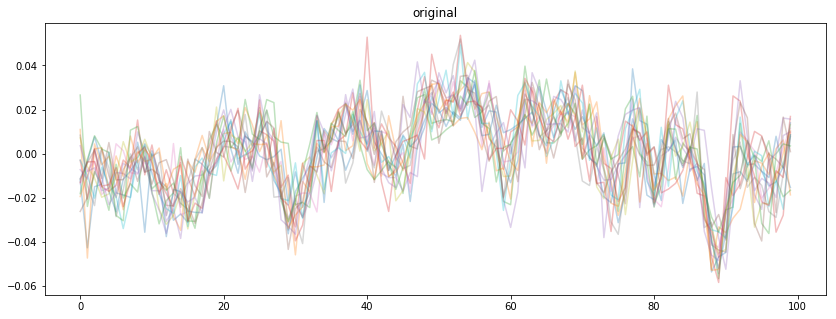

In [3]:
plt.figure(figsize=(14, 5))
plt.plot(x[0:100], alpha = 0.3)
plt.title('original')

In [4]:
S = np.zeros((1025,1281,16), dtype = np.complex64)
Smag = np.zeros((1025,1281,16), dtype = np.float32)
for i in range(16):
    S[:,:,i] = librosa.stft(x[:,i], hop_length=32)
    Smag[:,:,i] = librosa.magphase(S[:,:,i])[0]

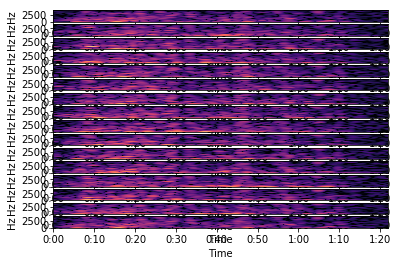

In [5]:
plt.figure(figsize=(20, 60))
for i in range(16):
    plt.subplot(16,1,i+1)
    librosa.display.specshow(librosa.amplitude_to_db(Smag[:,:,i]), sr=sr, x_axis='time', y_axis='linear')
    plt.set_cmap('magma')
    plt.clim(-20, 50)


In [6]:
n_components = 1024
model = NMF(n_components=n_components, init='nndsvd', solver='cd')
W = model.fit_transform(Smag[:,:,0])

In [7]:
H = np.zeros((1024,1281,16), dtype = np.float32)
H[:,:,0] = model.components_
print(W.shape)
print(H.shape)

(1025, 1024)
(1024, 1281, 16)


In [8]:
print(Smag.shape)

(1025, 1281, 16)


Text(0.5,1,'Frequency atoms')

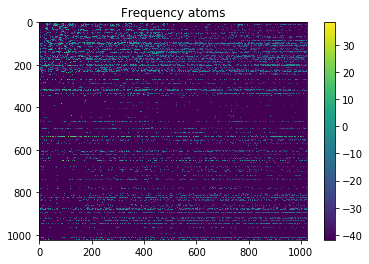

In [9]:
Wmag = librosa.amplitude_to_db(W)
plt.imshow(np.swapaxes(Wmag, 0, 1), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Frequency atoms')

In [52]:
for i in np.arange(1,16):
    H[:,:,i] = np.matmul(np.pinv(W), Smag[:,:,i])
    
print(H.shape)

ValueError: Array with wrong shape passed to NMF (input H). Expected (1024, 1281), but got (1024, 1025) 

0.06111066386913877


Text(0.5,1,'original')

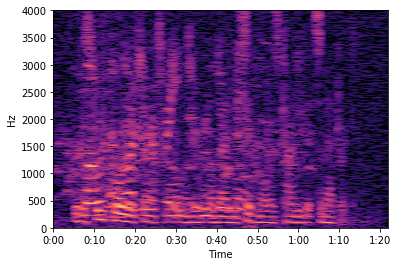

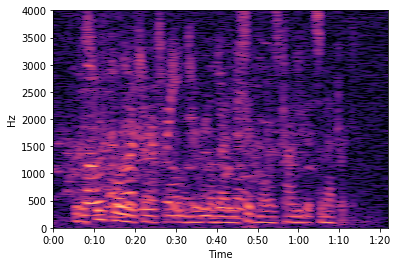

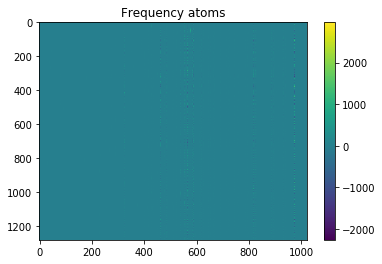

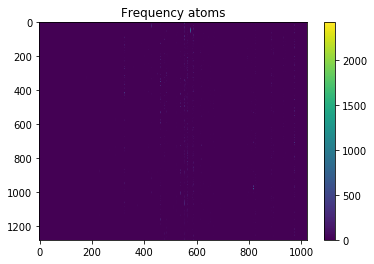

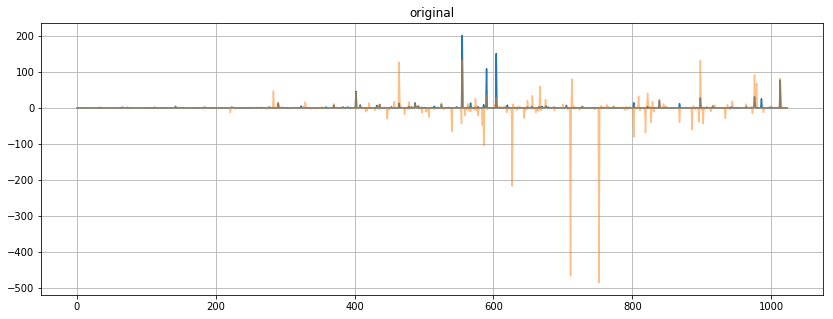

In [53]:
Htest = np.matmul(np.linalg.pinv(W), Smag[:,:,0])
Stest = np.matmul(W, H[:,:,0])

plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(Smag[:,:,0]), sr=sr, x_axis='time', y_axis='linear')
plt.set_cmap('magma')
plt.clim(-20, 50)
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(np.matmul(W, Htest)), sr=sr, x_axis='time', y_axis='linear')
plt.set_cmap('magma')
plt.clim(-20, 50)

residual = Smag[:,:,0] - np.matmul(W, H[:,:,0])
print(np.max(residual))

plt.figure()
plt.imshow(np.swapaxes(Htest, 0, 1), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Frequency atoms')

plt.figure()
plt.imshow(np.swapaxes(H[:, :, 0], 0, 1), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Frequency atoms')

atomSelect = 80
plt.figure(figsize=(14, 5))
plt.plot(H[:, atomSelect, 0], alpha = 1)
plt.plot(Htest[:, atomSelect], alpha = 0.5)
plt.grid(1)
plt.title('original')

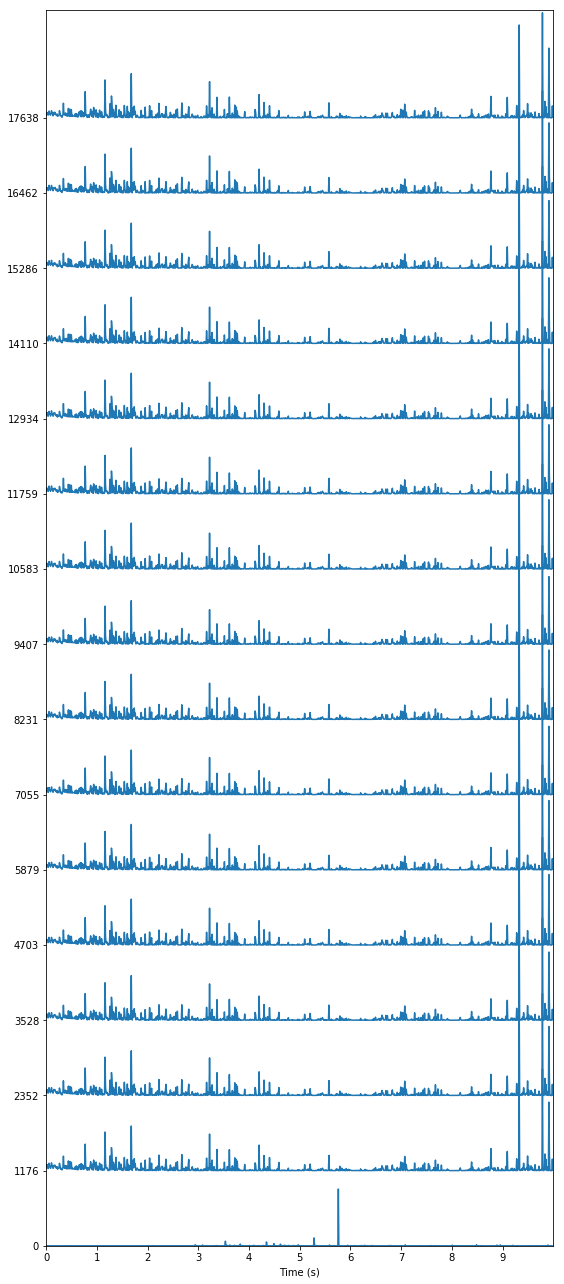

In [16]:
atomSelect = 23

from matplotlib.collections import LineCollection
from matplotlib.ticker import MultipleLocator

fig = plt.figure("Detail",figsize=(20, 50))
(numSamples, numRows) = H[:, atomSelect, :].shape
t = 10.0 * np.arange(numSamples) / numSamples
ticklocs = []
ax2 = fig.add_subplot(2, 2, 1)
ax2.set_xlim(0, 10)
ax2.set_xticks(np.arange(10))
dmin = H[:, atomSelect, :].min()
dmax = H[:, atomSelect, :].max()
dr = (dmax - dmin) * 0.7  # Crowd them a bit.
y0 = dmin
y1 = (numRows - 1) * dr + dmax
ax2.set_ylim(y0, y1)

segs = []
for i in range(numRows):
    segs.append(np.hstack((t[:, np.newaxis], H[:, atomSelect, i, np.newaxis])))
    ticklocs.append(i * dr)

offsets = np.zeros((numRows, 2), dtype=float)
offsets[:, 1] = ticklocs

lines = LineCollection(segs, offsets=offsets, transOffset=None)
ax2.add_collection(lines)

# Set the yticks to use axes coordinates on the y axis
ax2.set_yticks(ticklocs)

ax2.set_xlabel('Time (s)')


#plt.tight_layout()
plt.show()


Text(0.5,1,'original')

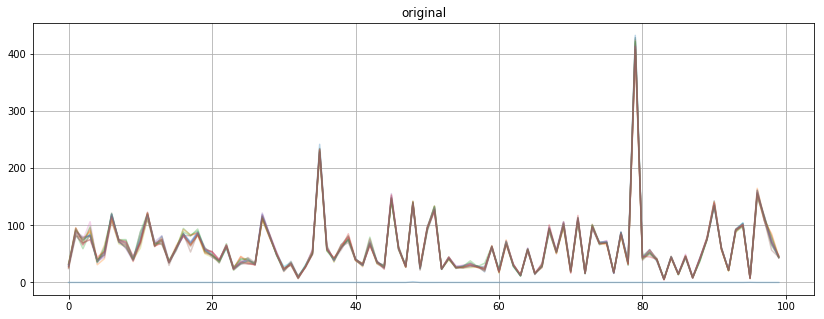

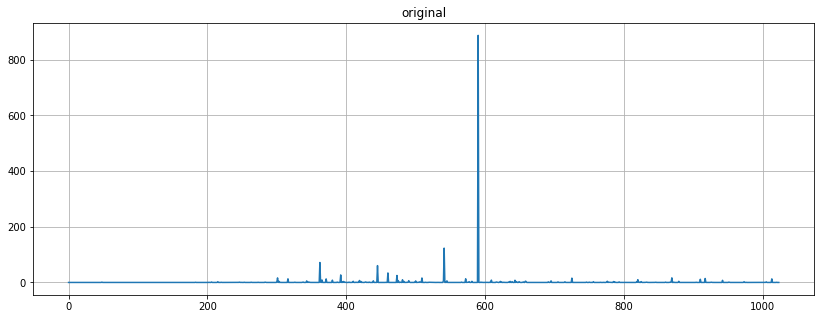

In [25]:
plt.figure(figsize=(14, 5))
plt.plot(H[:, atomSelect, :][0:100], alpha = 0.3)
plt.grid(1)
plt.title('original')

plt.figure(figsize=(14, 5))
plt.plot(H[:, atomSelect, 0]y)
plt.grid(1)
plt.title('original')

(1025, 1281)


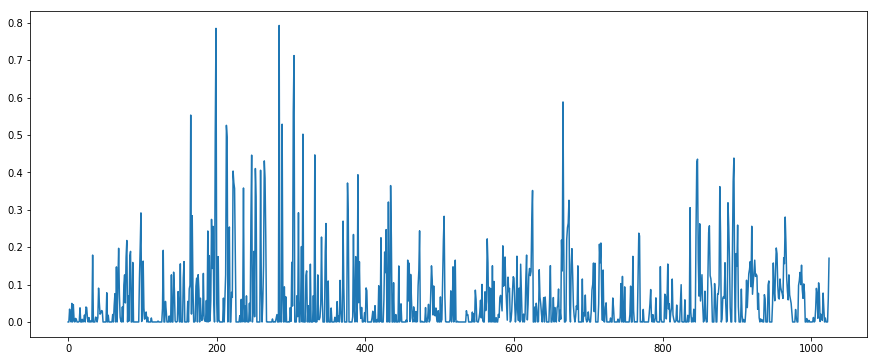

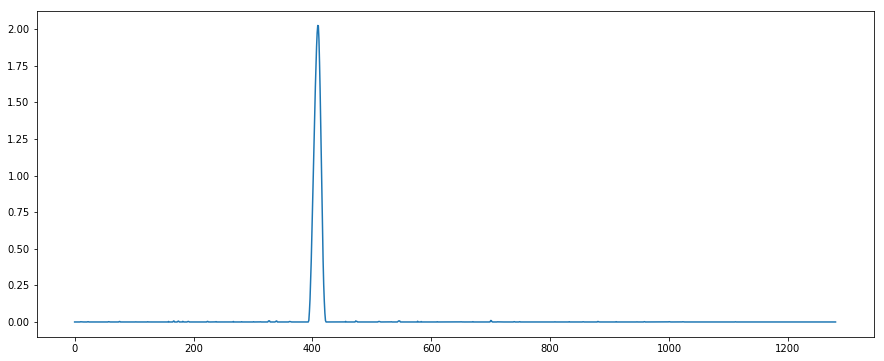

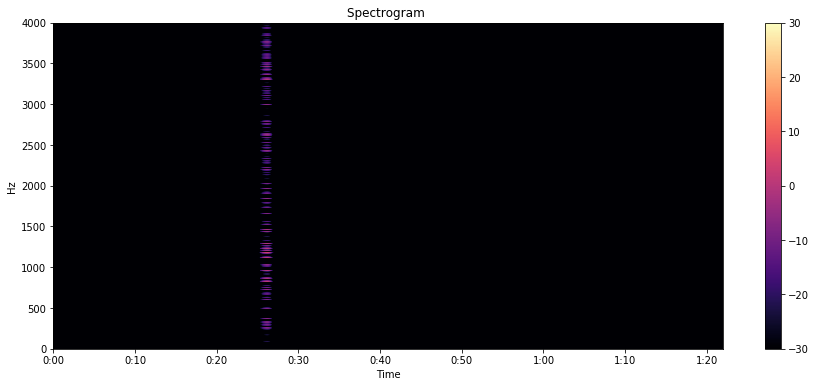

In [12]:
atomSelection = 430

plt.figure(figsize=(15, 6))
plt.plot(W[:,atomSelection])
plt.figure(figsize=(15, 6))
plt.plot(H[atomSelection,:])

atom1mask = W[:,atomSelection].reshape((W[:,1].shape[0], 1))*H[atomSelection,:]
print(atom1mask.shape)

plt.figure(figsize=(15, 6))
librosa.display.specshow(librosa.amplitude_to_db(atom1mask), sr=sr, x_axis='time', y_axis='linear')
plt.title('Spectrogram ')
plt.colorbar()
plt.clim(-30, 30);

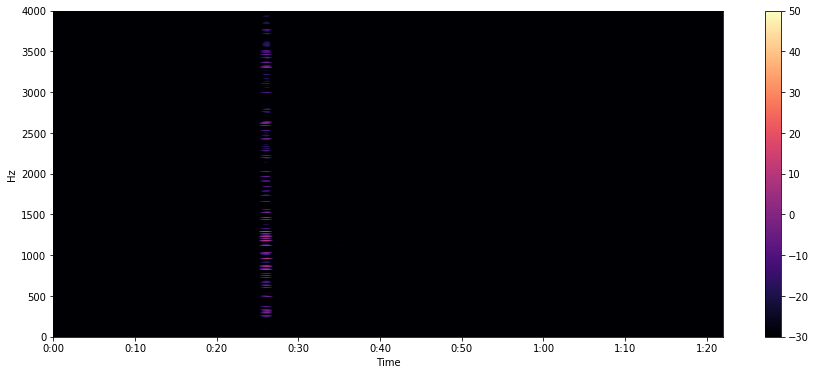

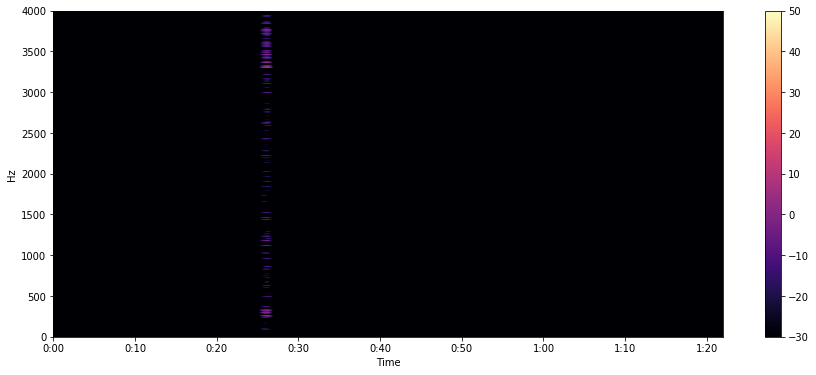

In [13]:
resultmag = np.multiply(Smag, atom1mask)
plt.figure(figsize=(15, 6))
#resultmag = librosa.magphase(result)[0]
librosa.display.specshow(librosa.amplitude_to_db(resultmag), sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.clim(-30, 50);

resultmagbf = np.multiply(Smagbf, atom1mask)
plt.figure(figsize=(15, 6))
#resultmagbf = librosa.magphase(resultbf)[0]
librosa.display.specshow(librosa.amplitude_to_db(resultmagbf), sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.clim(-30, 50);

Original :  1.9864382182340035
Beamformed :  1.0870234097501945


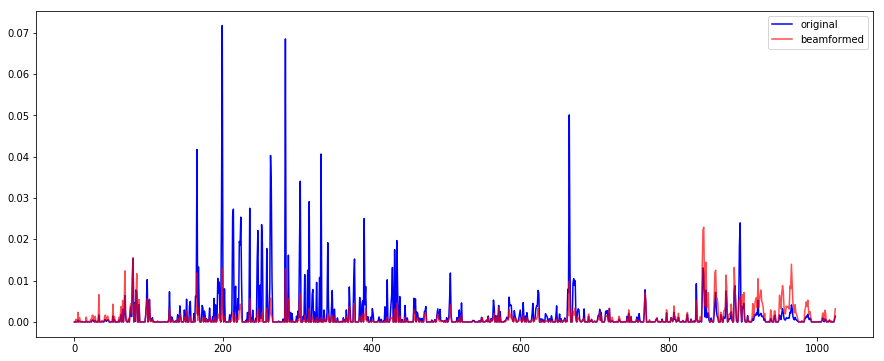

In [14]:
avg = np.average(resultmag, 1)
avgbf = np.average(resultmagbf, 1)

plt.figure(figsize=(15, 6))
plt.plot(avg, 'b')
plt.plot(avgbf, 'r', alpha=0.7)
plt.legend(('original', 'beamformed'))

instant = np.argmax(H[atomSelection,:])

power = np.sum(avg)
power2 = np.sum(librosa.magphase(S[:, instant])[0])
powerbf = np.sum(avgbf)
power2bf = np.sum(librosa.magphase(Sbf[:, instant])[0])

print('Original : ', power)
print('Beamformed : ', powerbf)

In [15]:
mask = np.zeros(n_components)
for i in range(n_components):
    atom1mask = W[:,i].reshape((W[:,1].shape[0], 1))*H[i,:]
    resultmag = np.multiply(Smag, atom1mask)
    resultmagbf = np.multiply(Smagbf, atom1mask)
    avg = np.average(resultmag, 1)
    avgbf = np.average(resultmagbf, 1)
    if(np.sum(avgbf) > np.sum(avg)):
        mask[i] = 1;

In [16]:
print(mask)

[0. 0. 0. ... 1. 0. 1.]


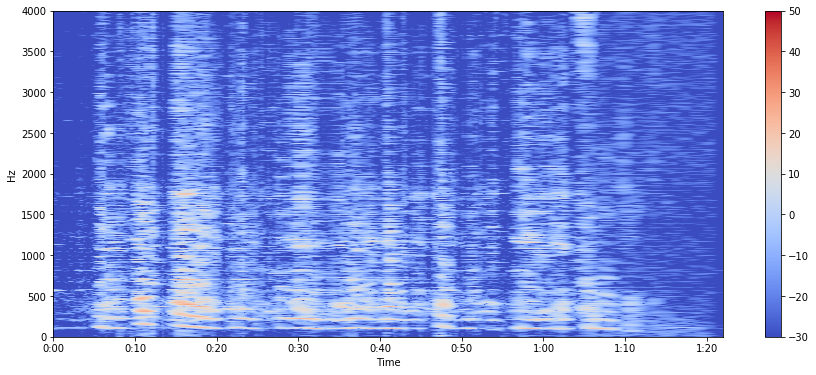

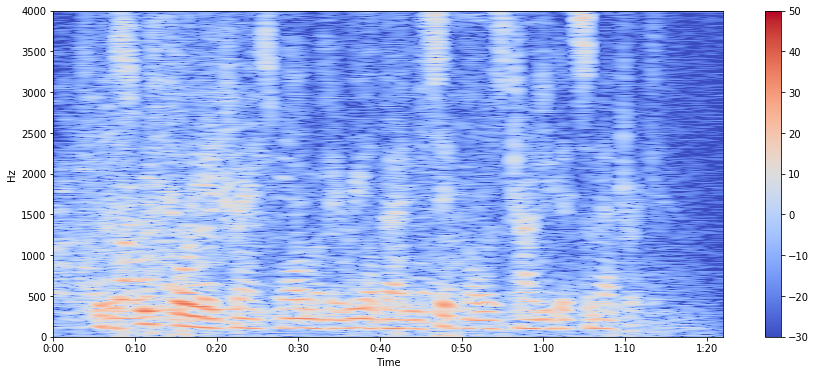

In [28]:
sourcemag = np.zeros(Smag.shape)
for i in range(n_components):
    if(mask[i]!=0):
        sourcemag = sourcemag + sp.outer(W[:,i], H[i, :])
        
# PLOTTING
plt.figure(figsize=(15, 6))
librosa.display.specshow(librosa.amplitude_to_db(sourcemag), sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.clim(-30, 50);
plt.figure(figsize=(15, 6))
librosa.display.specshow(librosa.amplitude_to_db(Smagbf), sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.clim(-30, 50);

In [29]:
reconstructed_signal = sp.zeros(len(x))
Y = sourcemag*np.exp(1j*np.angle(Sbf))
y = librosa.istft(Y, hop_length=32)

reconstructed_signal[:len(y)] += y
reconstructed_signal.resize(y.shape)

reconstructed_signal2 = sp.zeros(len(x))
Y2 = Smagbf*np.exp(1j*np.angle(Sbf))
y2 = librosa.istft(Y2, hop_length=32)

reconstructed_signal2[:len(y2)] += y2
reconstructed_signal2.resize(y2.shape)

voice_dft, sr = librosa.load('media/dft_voice_8kHz.wav', sr=None)
voice_cleanspeech, sr = librosa.load('media/cleanspeech_voice_8kHz.wav', sr=None)
voice_laugh, sr = librosa.load('media/laughter_8kHz.wav', sr=None)

voice_laugh = 2*voice_laugh

voice_dft.resize(y.shape)
voice_cleanspeech.resize(y.shape)
voice_laugh.resize(y.shape)

ipd.display( ipd.Audio(x, rate=sr) )
ipd.display( ipd.Audio(reconstructed_signal, rate=sr) )

noisePwr = 1e-4
snrBefore = librosa.power_to_db(np.average((voice_cleanspeech+voice_laugh)**2+noisePwr)/
                                np.average((bf - voice_dft)**2))
snrAfter = librosa.power_to_db(np.average((voice_cleanspeech+voice_laugh)**2+noisePwr)/
                                np.average((reconstructed_signal - voice_dft)**2))

print('before : ', snrBefore)
print('after : ', snrAfter)

before :  15.615167895424571
after :  9.332406384751723


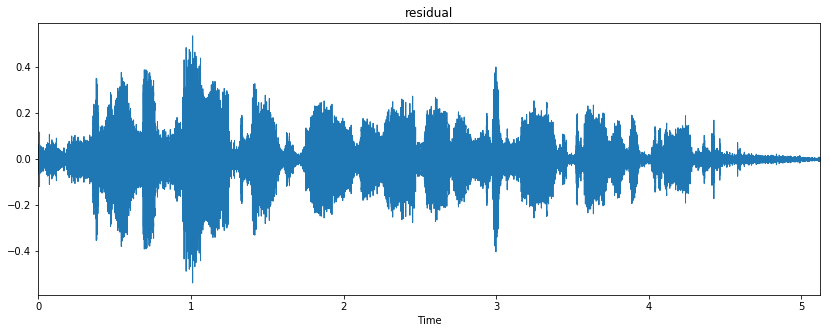

In [19]:
residual = np.abs(reconstructed_signal2 - reconstructed_signal)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(residual, sr=sr)
plt.title('residual')

ipd.display( ipd.Audio(residual, rate=sr) )

In [20]:
print(W.shape)

(1025, 1024)
